In [1]:
import torch
from diffusers import FluxPipeline
torch.set_grad_enabled(False)
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:

from loguru import logger
import shutil
import orbax.checkpoint as ocp
from pathlib import Path
import jax
import os
os.environ["JAX_PLATFORMS"] = "cpu"


def restore_array(path):
    with jax.default_device(jax.devices("cpu")[0]):
        checkpointer = ocp.PyTreeCheckpointer()
        vals_meta = checkpointer.metadata(path)
        sharding = jax.sharding.SingleDeviceSharding(jax.devices("cpu")[0])
        restore_args = ocp.checkpoint_utils.construct_restore_args(
            vals_meta,
            sharding_tree=jax.tree.map(lambda _: sharding, vals_meta)
        )
        restored_vals = checkpointer.restore(path, restore_args=restore_args)
    return restored_vals


layer = 18

In [3]:
sae_mid = restore_array(os.path.abspath(
    f"flux1-saes/sae_double_l{layer}_img/30000/default"))

In [35]:
import numpy as np
import torch

fs_means = sae_mid["info"]["feature_means"]
fs_sq_means = sae_mid["info"]["feature_square_means"]

stds = np.sqrt(np.maximum(fs_sq_means - np.square(fs_means), 1e-6))
wm = sae_mid["info"]["whitening_matrix"]

w_dec_in = (sae_mid["sae_params"]["W_dec"] / stds) @ wm.T
w_dec_out = (sae_mid["sae_params"]["W_dec"] * stds) @ wm.T

w_dec_in = torch.tensor(w_dec_in)
w_dec_out = torch.tensor(w_dec_out)
w_dec_in = w_dec_in / w_dec_in.norm(dim=1, keepdim=True)
w_dec_out = w_dec_out / w_dec_out.norm(dim=1, keepdim=True)

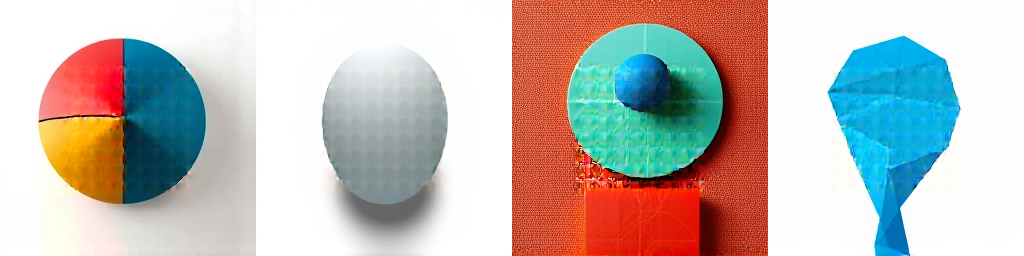

In [ ]:
from collections import OrderedDict
from PIL import Image
for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()

height = 256
width = 256
guidance_scale = 3.5
num_inference_steps = 20
steering_strength = 0.8
feature_id = 3796
steer_bounds = 4
steer_in = False
n_generate = 4
# prompts = ["An object on a white background"]
# prompts = ["A photo"]
prompts = ["A head made out of a material"]
# prompts = ["A textured pattern"]


def callback_on_step_end(self, i, t, kwargs):
    global timestep
    timestep = i
    return {}


pipe.set_progress_bar_config(disable=True)


def patch_hook(self, input, output):
    image_output = output[1]
    image_output = image_output.unflatten(1, (height // 16, width // 16))
    nrm = steering_strength \
        * image_output.norm(dim=-1, keepdim=True).mean()
    image_output[..., steer_bounds:-steer_bounds, steer_bounds:-steer_bounds, :] += \
        (w_dec_in if steer_in else w_dec_out)[
        feature_id].to(image_output) * nrm
    image_output = image_output.flatten(1, 2)
    return output[:1] + (image_output,) + output[2:]


pipe.transformer.transformer_blocks[layer].register_forward_hook(patch_hook)
with torch.inference_mode():
    images = pipe(
        prompts,
        height=height,
        width=width,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=n_generate,
        max_sequence_length=512,
        generator=torch.Generator("cpu").manual_seed(0),
        return_dict=False,
    )[0]
Image.fromarray(np.concatenate(list(map(np.asarray, images)), axis=1))

TypeError: 'Image' object is not subscriptable

In [ ]:
from collections import OrderedDict

with torch.inference_mode():
    for m in pipe.transformer.modules():
        m._forward_hooks = OrderedDict()

NameError: name 'torch' is not defined